# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import copy

In [2]:
from torch.utils.tensorboard import SummaryWriter

# Dataset

In [3]:
with open('../../model/config.json', 'rb') as file:
    config = json.load(file)
csop_cols_to_ignore = config['csop']['cols_to_ignore']
csopII_cols_to_ignore = config['csopII']['cols_to_ignore']
csop_target, csopII_target = 'zscore_efficiency', 'efficiency'

In [4]:
csop_raw = pd.read_csv('../../output/csop_output_conversation_level.csv')
csop_all_features = csop_raw.drop(csop_cols_to_ignore, axis=1)
target_scaler = StandardScaler()
csop_all_features['target'] = target_scaler.fit_transform(csop_raw[csop_target].to_numpy().reshape(-1, 1))

csopII_raw = pd.read_csv('../../output/csopII_output_conversation_level.csv')
csopII_all_features = csopII_raw.drop(csopII_cols_to_ignore, axis=1)
csopII_all_features['target'] = target_scaler.transform(csopII_raw[csopII_target].to_numpy().reshape(-1, 1))

features = list(set(csop_all_features.columns).intersection(set(csopII_all_features.columns)))
csop, csopII = csop_all_features[features].copy(), csopII_all_features[features].copy()
csop, csopII = csop.fillna(0), csopII.fillna(0)

In [5]:
X, y = csop.drop(['target'], axis=1), csop[['target']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_test, y_test = csopII.drop(['target'], axis=1), csopII[['target']]

feature_scaler = StandardScaler()
X_train = pd.DataFrame(feature_scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns)
X_val = pd.DataFrame(feature_scaler.transform(X_val.to_numpy()), columns=X_val.columns)
X_test = pd.DataFrame(feature_scaler.transform(X_test.to_numpy()), columns=X_test.columns)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((882, 390), (98, 390), (962, 390), (882, 1), (98, 1), (962, 1))

In [6]:
feature_groupings_raw = pd.read_excel('feature_groupings_06_20_23.xlsx')
groups = feature_groupings_raw.columns[2:]
groups

Index(['Communication Frequency', 'Information / Knowledge Exchange',
       'Linguistic Features', 'Emotion', 'Cognitive Processes',
       'Perceptual Processes', 'Social Processes', 'Biological Processes',
       'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
       'Hedging', 'Politeness', 'Equality'],
      dtype='object')

In [7]:
rows = []
for idx, row in tqdm(feature_groupings_raw.iterrows(), total=feature_groupings_raw.shape[0]):
    if row['Level'] == 'Chat':
        for prefix in ['min_', 'max_', 'stdev_', 'average_']:
            feature_name = prefix + row['Feature Name']
            row_to_append = [feature_name] + row[groups].to_list()
            rows.append(row_to_append)
    else:
        feature_name = row['Feature Name']
        row_to_append = [feature_name] + row[groups].to_list()
        rows.append(row_to_append)
feature_groupings = pd.DataFrame(
    rows, 
    columns= [
        'Feature Name', 'Communication Frequency', 'Information / Knowledge Exchange',
        'Linguistic Features', 'Emotion', 'Cognitive Processes',
        'Perceptual Processes', 'Social Processes', 'Biological Processes',
        'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
        'Hedging', 'Politeness', 'Equality'
    ]
)

100%|██████████| 99/99 [00:00<00:00, 1974.04it/s]


## Creating Data Loaders

In [8]:
class CSOPDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [9]:
train_dataset = CSOPDataset(X=X_train.to_numpy(), y=y_train.to_numpy())
val_dataset = CSOPDataset(X=X_val.to_numpy(), y=y_val.to_numpy())

In [10]:
torch.manual_seed(42)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

# Fully Connected Neural Network

## Model Definition

In [11]:
class CSOPFullyConnectedNN(nn.Module):
    def __init__(self, num_input_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=num_input_features, out_features=15),
            nn.ReLU(),
            nn.Linear(in_features=15, out_features=1)
        )

    def forward(self, X):
        return self.net(X)

In [12]:
fully_connected_nn = CSOPFullyConnectedNN(num_input_features=X_train.shape[1])

## Model Training Setup

In [13]:
loss_fn = nn.MSELoss()
learning_rate = 0.00003
optimizer = Adam(params=fully_connected_nn.parameters(), lr=learning_rate)
max_epochs = 200

In [14]:
best_mse = float('inf')
best_weights = None
train_losses, val_losses = [], []

In [15]:
writer = SummaryWriter('feature_bagging_nn_models/runs')

## Model Training Loop

In [16]:
for epoch in range(max_epochs):
    # Training for one epoch
    fully_connected_nn.train()
    train_loss = 0
    with tqdm(list(range(len(train_dataloader))), unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f'Epoch: {epoch}')
        for (X_batch, y_batch), start in zip(train_dataloader, bar):
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = fully_connected_nn(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Weights Updates
            optimizer.step()
            # Print Progress
            bar.set_postfix(mse=float(loss))
            train_loss += float(loss)
    # Calculating average training loss after one epoch
    avg_train_mse_loss = float(train_loss/len(train_dataloader))
    train_losses.append(avg_train_mse_loss)
    writer.add_scalar('Training Loss', avg_train_mse_loss, epoch)
    # Validation after one epoch
    fully_connected_nn.eval()
    val_loss = 0
    for X_batch, y_batch in val_dataloader:
        # Forward Pass
        X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
        y_pred = fully_connected_nn(X_batch)
        val_mse_loss = loss_fn(y_pred, y_batch)
        val_loss += float(val_mse_loss)
    # Calculating average validation loss after one epoch
    avg_val_mse_loss = float(val_loss/len(val_dataloader))
    val_losses.append(avg_val_mse_loss)
    writer.add_scalar('Validation Loss', avg_val_mse_loss, epoch)
    # Checking if we improved from the previous best epoch
    if avg_val_mse_loss < best_mse:
        best_mse = avg_val_mse_loss
        best_weights = copy.deepcopy(fully_connected_nn.state_dict())

Epoch: 199:  93%|█████████▎| 13/14 [00:00<00:00, 337.71batch/s, mse=0.54] 


In [17]:
fully_connected_nn.load_state_dict(best_weights)
model_path = f'feature_bagging_nn_models/fully_connected_nn_best_model'
torch.save(fully_connected_nn.state_dict(), model_path)

Best Validation MSE: 0.8127398490905762


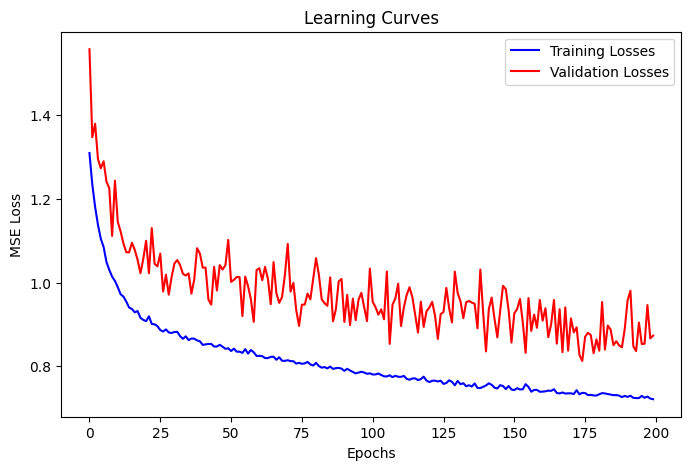

In [18]:
print(f'Best Validation MSE: {best_mse}')
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_losses, color='blue', label='Training Losses')
ax.plot(val_losses, color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()

In [19]:
def calc_nn_metrics(y_true, y_pred, type='TRAIN'):
    r2 = r2_score(y_true=y_true, y_pred=y_pred).round(4)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred).round(4)
    rmse = np.sqrt(mse).round(4)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred).round(4)

    print(f'{type} METRICS')
    print(f'R2: {r2}\tMSE: {mse}\tRMSE: {rmse}\tMAE: {mae}')

In [20]:
train_preds = fully_connected_nn(torch.tensor(X_train.to_numpy(), dtype=torch.float32)).detach().numpy()
val_preds = fully_connected_nn(torch.tensor(X_val.to_numpy(), dtype=torch.float32)).detach().numpy()

In [21]:
calc_nn_metrics(y_true=y_train, y_pred=train_preds, type='TRAIN')

TRAIN METRICS
R2: 0.2566	MSE: 0.7342	RMSE: 0.8569	MAE: 0.6345


In [22]:
calc_nn_metrics(y_true=y_val, y_pred=val_preds, type='VALIDATION')

VALIDATION METRICS
R2: 0.1893	MSE: 0.8942	RMSE: 0.9456	MAE: 0.7745


## Weights Visualization

In [23]:
ip_weights = fully_connected_nn.net[0].weight.detach().numpy()
ip_weights_df = pd.DataFrame(columns=[
    'Feature', 
    'Weight1', 'Weight2', 'Weight3', 
    'Weight4', 'Weight5', 'Weight6', 
    'Weight7', 'Weight8', 'Weight9', 
    'Weight10', 'Weight11', 'Weight12', 
    'Weight13', 'Weight14', 'Weight15'
])
ip_weights_df['Feature'] = X_train.columns
ip_weights_df.iloc[:, 1:] = ip_weights.T
ip_weights_df

/var/folders/xt/g8l4wmks0vdfkcs7td5kd6dh0000gn/T/ipykernel_37200/3207441322.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ip_weights_df.iloc[:, 1:] = ip_weights.T


,Feature,Weight1,Weight2,Weight3,Weight4,Weight5,Weight6,Weight7,Weight8,Weight9,Weight10,Weight11,Weight12,Weight13,Weight14,Weight15
0,average_indefinite_pronoun,0.049916,-0.002153,0.001199,-0.006909,0.023970,-0.036179,0.039056,0.012012,0.002045,-0.024280,0.016157,-0.021598,-0.027562,0.000932,-0.008733
1,max_2nd_person,0.057391,-0.028956,-0.017493,0.000087,0.031698,-0.004062,0.008964,0.013627,-0.021039,0.004933,-0.038086,0.040671,0.001735,-0.035495,-0.017517
2,max_exclusive,-0.015434,0.025534,0.021070,-0.006882,0.035938,-0.004608,-0.024148,-0.015695,-0.017298,-0.004088,0.001631,0.013997,-0.033353,0.011847,-0.026063
3,average_anxiety,0.040349,0.010328,0.016550,0.004264,-0.034671,-0.000178,-0.022914,0.041944,-0.048955,0.036529,-0.041757,-0.012253,-0.005851,0.018792,0.036878
4,stdev_first_person_plural,-0.023643,0.017642,-0.017085,0.050775,-0.002826,-0.023165,0.031221,0.028017,0.026213,0.032716,-0.035686,0.007370,0.003111,0.013744,0.032618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,min_first_person,0.046158,-0.006083,0.035743,0.002019,0.043069,-0.032701,-0.019365,-0.017706,0.018480,-0.005624,-0.008517,0.003631,0.000319,0.048639,0.001059
386,average_1st_person_start,-0.035625,-0.017551,-0.043521,-0.024902,-0.029700,0.010343,0.019568,-0.056241,0.055103,-0.041042,-0.014753,0.039635,0.010062,-0.039092,0.011200
387,max_num_words,-0.020614,0.004458,0.002159,-0.038070,-0.040641,-0.002443,-0.052083,0.041393,-0.055595,-0.025581,0.044388,0.015789,-0.020998,-0.001317,-0.041343
388,average_present_tense,0.040016,0.015589,-0.039783,-0.041447,0.060619,-0.001699,0.018278,-0.011726,0.044488,-0.031982,0.007130,-0.028461,0.036117,0.042307,0.054923


In [24]:
final_weights = fully_connected_nn.net[2].weight.detach().numpy()
final_weights_df = pd.DataFrame(columns=['Node', 'Weight'])
final_weights_df['Node'] = [str(node) for node in list(range(1, 16))]
final_weights_df['Weight'] = final_weights.T
final_weights_df

,Node,Weight
0,1,-0.254124
1,2,-0.089159
2,3,0.237417
3,4,0.036627
4,5,-0.134396
5,6,0.159848
6,7,0.184680
7,8,0.171777
8,9,-0.060188
9,10,-0.061616
